In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import warnings
import gc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
submit_df = pd.read_csv("./submit_sample.csv", header=None)


In [8]:
# google colab
train_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/signate/train.csv")
test_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/signate/test.csv")
submit_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/signate/submit_sample.csv", header=None)

In [9]:
train_df.shape, test_df.shape, submit_df.shape

((27100, 18), (18050, 17), (18050, 2))

In [10]:
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0


<BarContainer object of 42 artists>

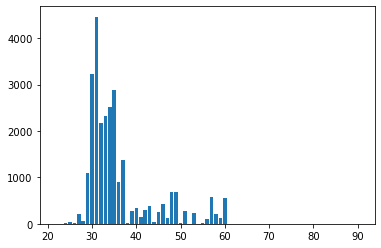

In [ ]:
# それぞれの年齢におけるターゲットの数
plt.bar(train_df['age'].value_counts().sort_index().index, train_df['age'].value_counts().sort_index())

####  0  ~  9
#############################


####  10  ~  19
#############################


####  20  ~  29
#############################
22 1 1.0
24 8 1.0
25 35 5.0
26 10 3.0
27 222 13.0
28 66 7.0
29 1104 190.0
num_people is  1446


####  30  ~  39
#############################
30 3226 242.0
31 4464 202.0
32 2176 210.0
33 2318 135.0
34 2521 90.00000000000001
35 2888 123.00000000000001
36 907 31.0
37 1368 170.0
38 12 0.0
39 270 24.0
num_people is  20150


####  40  ~  49
#############################
40 333 28.999999999999996
41 153 5.0
42 307 46.0
43 385 22.0
44 39 5.0
45 252 28.0
46 435 53.0
47 115 5.0
48 675 54.0
49 683 76.0
num_people is  3377


####  50  ~  59
#############################
50 18 3.0
51 279 16.0
52 5 1.0
53 236 51.0
54 4 1.0
55 11 3.0
56 104 9.0
57 573 44.0
58 222 49.0
59 116 8.0
num_people is  1568


####  60  ~  69
#############################
60 546 157.0
63 6 0.0
num_people is  552


####  70  ~  79
#############################
73 1 0.0
77 1 0.0


####  80 

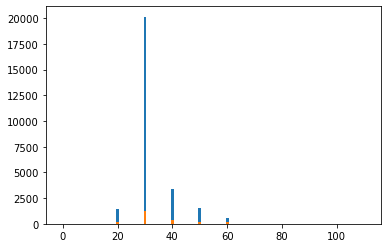

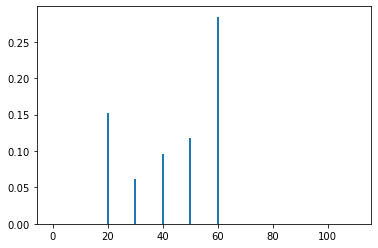

In [ ]:
period = range(0, 120, 10)

# index : age (pandas Series obj)
#print(target_df["age"])
# the number of "y" in each colmun (numpy Array)
#print(np.array(target_df['y']) * np.array(train_df['age'].value_counts().sort_index()))
# list of age
#print(train_df['age'].value_counts().sort_index().index)

list_age = train_df['age'].value_counts().sort_index().index
target_df = train_df.groupby(['age'], as_index=False).mean()
sum_y = np.array(target_df['y']) * np.array(train_df['age'].value_counts().sort_index())


index = 0
num_people_list = np.zeros(len(period))
prob = np.zeros(len(period))
for i, lim_age in enumerate(period):
    num_people = 0
    print("#### ", lim_age, " ~ ", lim_age+10-1)
    print("#############################")
    for j, age in enumerate(list_age):
        if (age >= lim_age ) and (age < lim_age+10):
            print(age, np.array(train_df['age'].value_counts().sort_index())[j], sum_y[j])
            num_people += np.array(train_df['age'].value_counts().sort_index())[j]
            prob[i] += sum_y[j]
            index += 1
        else:
            if(lim_age+10-1 < age):
                break
    if (max(list_age) > age) and (num_people != 0):
        print("num_people is ", num_people)
        num_people_list[i] = num_people
        prob[i] /= num_people
    print("\n")

#num_people_list /= np.sum(num_people_list)    

#plt.show()
plt.bar(period, num_people_list, width=1)
plt.bar(period, prob*num_people_list, width=1)
plt.show()

plt.bar(period, prob)
plt.show()


In [ ]:
# それぞれの年間平均残高におけるターゲットの数
tmp = round(train_df['balance'], -1).value_counts().sort_index()

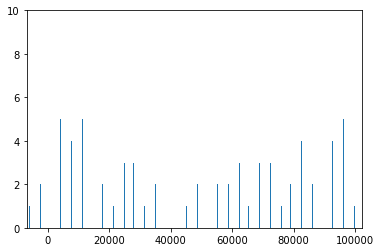

In [ ]:
plt.bar(tmp.index, tmp)
plt.xlim(min(tmp.index), max(tmp.index))
plt.ylim(0, max(tmp))
plt.show()

In [ ]:
def relationship(feature):
    tmp = train_df[feature].value_counts().sort_index()
    print(tmp.index)
    print(feature, "とキャンペーン参加人数の関係")
    plt.bar(range(len(tmp.index)), np.array(tmp))
    plt.bar(np.array(range(len(tmp.index))), np.array(tmp)*np.array(train_df.groupby([feature], as_index=False).mean()['y']))
    plt.show()

    print(feature, "とキャンペーン参加率の関係")
    plt.bar(range(len(tmp.index)), np.array(train_df.groupby([feature], as_index=False).mean()['y']))
    plt.show()

In [ ]:
print(train_df.columns.values)

['id' 'age' 'job' 'marital' 'education' 'default' 'balance' 'housing'
 'loan' 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome' 'y']


Index(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'retired', 'self-employed', 'services', 'student', 'technician',
       'unemployed'],
      dtype='object')
job とキャンペーン参加人数の関係


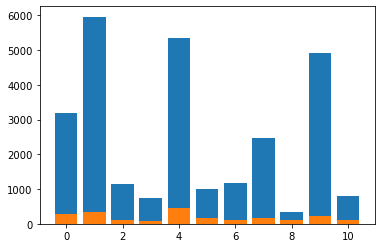

job とキャンペーン参加率の関係


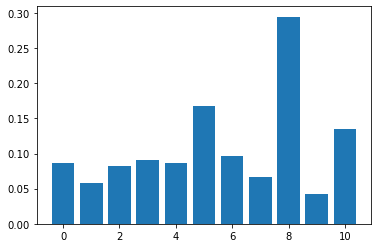

In [ ]:
relationship("job")

Int64Index([22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
            40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
            57, 58, 59, 60, 63, 73, 77, 90],
           dtype='int64')
age とキャンペーン参加人数の関係


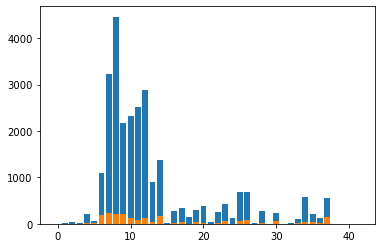

age とキャンペーン参加率の関係


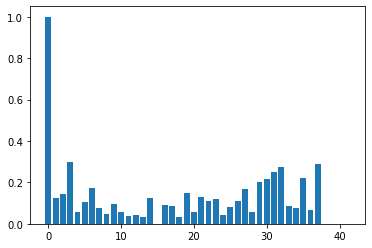

Index(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'retired', 'self-employed', 'services', 'student', 'technician',
       'unemployed'],
      dtype='object')
job とキャンペーン参加人数の関係


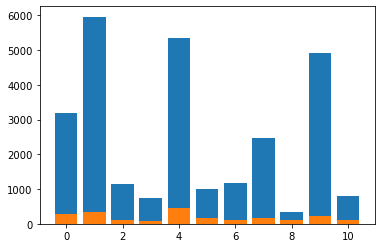

job とキャンペーン参加率の関係


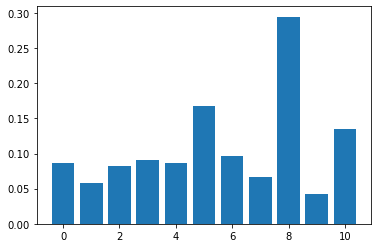

Index(['divorced', 'married', 'single'], dtype='object')
marital とキャンペーン参加人数の関係


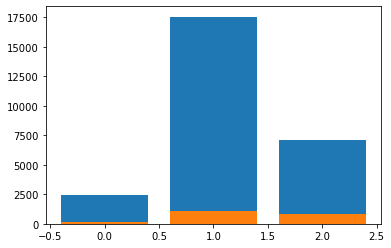

marital とキャンペーン参加率の関係


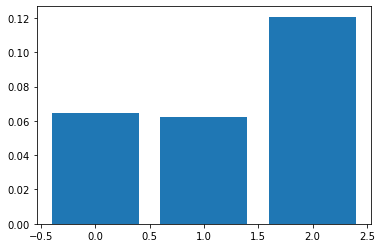

Index(['primary', 'secondary', 'tertiary', 'unknown'], dtype='object')
education とキャンペーン参加人数の関係


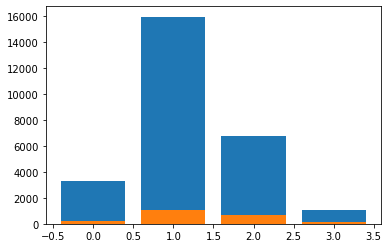

education とキャンペーン参加率の関係


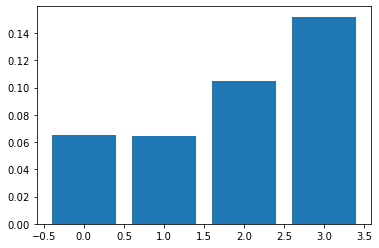

Index(['no', 'yes'], dtype='object')
default とキャンペーン参加人数の関係


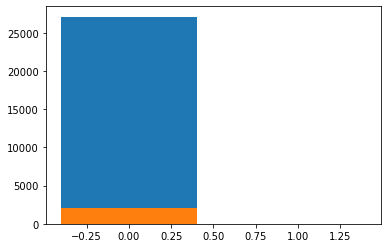

default とキャンペーン参加率の関係


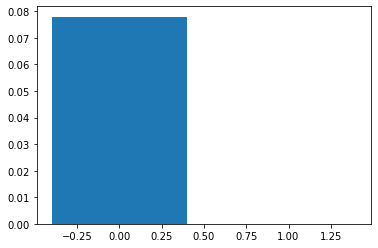

Int64Index([ -6847,  -6846,  -6843,  -6841,  -6839,  -6834,  -6824,  -6817,
             -6814,  -6806,
            ...
            102090, 102091, 102100, 102101, 102105, 102110, 102115, 102116,
            102117, 102121],
           dtype='int64', length=23967)
balance とキャンペーン参加人数の関係


In [ ]:
f_list = [ 'age', 'job', 'marital', 'education', 'default', 'balance', 'housing','loan',
          'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome' ]
for f_name in f_list:
    relationship(f_name)

In [ ]:
# 年齢ごとの職業など可視化

In [51]:
def relationship_age(feature):
    tmp_df = train_df
    for age_lim in range(0, int(np.ceil(max(train_df['age']))), 10):
        print("###########################")
        print("#######", age_lim, "～", age_lim+10-1)
        print("###########################")
        sort_age_series = tmp_df.query('@age_lim <= age < @age_lim+10')[feature].value_counts().sort_index()
        if len(sort_age_series) != 0:
            print(sort_age_series)
            plt.pie(sort_age_series, labels=sort_age_series.index)
            plt.show()
        else:
            print("No data\n")




###########################
####### 0 ～ 9
###########################
No data

###########################
####### 10 ～ 19
###########################
No data

###########################
####### 20 ～ 29
###########################
admin.           254
blue-collar      220
entrepreneur     143
housemaid         57
management       222
retired          104
self-employed    115
services          68
student           70
technician       101
unemployed        92
Name: job, dtype: int64


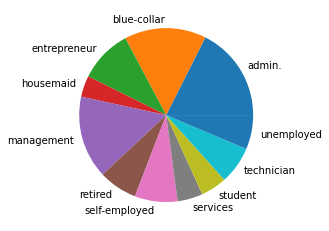

###########################
####### 30 ～ 39
###########################
admin.           2399
blue-collar      4960
entrepreneur      647
housemaid         266
management       4287
retired           174
self-employed     724
services         1983
student           226
technician       4175
unemployed        309
Name: job, dtype: int64


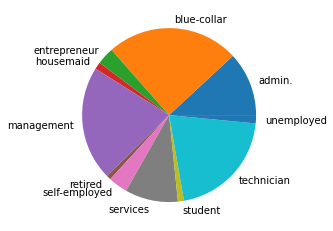

###########################
####### 40 ～ 49
###########################
admin.           400
blue-collar      555
entrepreneur     304
housemaid        294
management       479
retired          125
self-employed    261
services         322
student           19
technician       363
unemployed       255
Name: job, dtype: int64


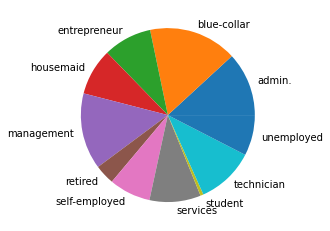

###########################
####### 50 ～ 59
###########################
admin.           114
blue-collar      163
entrepreneur      38
housemaid        117
management       253
retired          373
self-employed     50
services          91
student           11
technician       253
unemployed       105
Name: job, dtype: int64


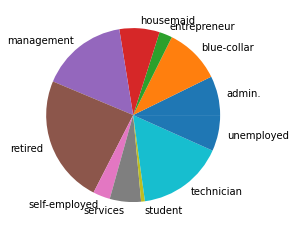

###########################
####### 60 ～ 69
###########################
admin.            20
blue-collar       59
entrepreneur      22
housemaid         20
management       105
retired          225
self-employed     13
services           5
student           27
technician        22
unemployed        34
Name: job, dtype: int64


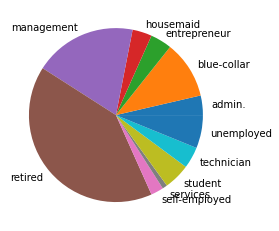

###########################
####### 70 ～ 79
###########################
retired       1
technician    1
Name: job, dtype: int64


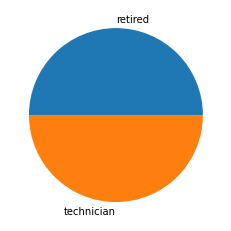

###########################
####### 80 ～ 89
###########################
No data



In [52]:
relationship_age("job")

0
10
20
primary      168
secondary    752
tertiary     373
unknown      153
Name: education, dtype: int64


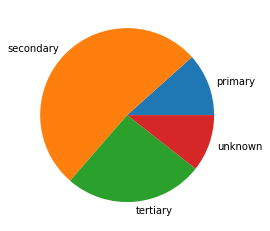

30
primary       1812
secondary    12744
tertiary      5078
unknown        516
Name: education, dtype: int64


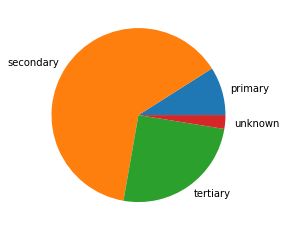

40
primary       758
secondary    1546
tertiary      790
unknown       283
Name: education, dtype: int64


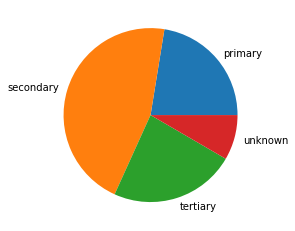

50
primary      478
secondary    697
tertiary     332
unknown       61
Name: education, dtype: int64


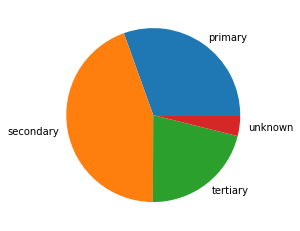

60
primary      111
secondary    211
tertiary     164
unknown       66
Name: education, dtype: int64


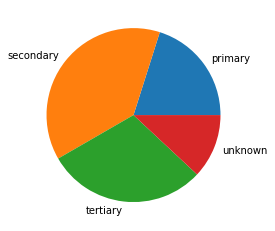

70
primary      1
secondary    1
Name: education, dtype: int64


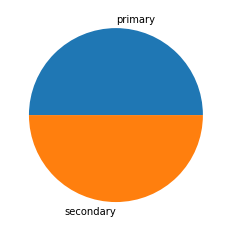

80


In [46]:
relationship_age("education")